In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pyvis.network import Network
from pyvis.options import Layout
import networkx as nx

In [2]:
@dataclass
class Block:
    id: int
    t: float
    height: int
    parent: int
    leader: int

In [3]:
@dataclass
class NetworkParams:
    mixnet_delay_mean: int # seconds
    mixnet_delay_var: int
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds

    def sample_mixnet_delay(self):
        scale = self.mixnet_delay_var / self.mixnet_delay_mean
        shape = self.mixnet_delay_mean / scale
        return np.random.gamma(shape=shape, scale=scale)
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_time(self, block_time):
        return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_time) + block_time

In [4]:
@dataclass
class Params:
    TIME: int
    MEAN_BLOCK_TIME: int
    honest_hash_power: np.array
    adversary_control: float

    @property
    def N(self):
        return len(self.hash_power)

    @property
    def hash_power(self):
        return np.append(self.honest_hash_power, self.honest_hash_power.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_hash_power(self):
        return self.hash_power / self.hash_power.sum()

    def next_block(self):
        return np.random.exponential(self.MEAN_BLOCK_TIME / self.relative_hash_power)

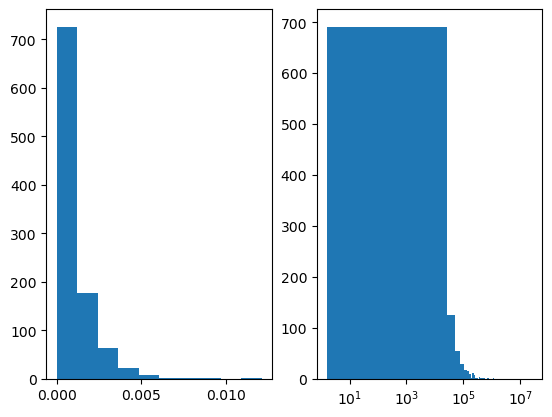

In [5]:
np.random.seed(0)

params = Params(
    TIME=60 * 60, # seconds
    MEAN_BLOCK_TIME=10*60,
    honest_hash_power = np.random.pareto(10, size=1000),
    adversary_control=0.001,
)
ax = plt.subplot(121)
ax.hist(params.relative_hash_power)
ax = plt.subplot(122)
next_block_times = params.next_block()
ax.hist(next_block_times / 60, bins=1000)
ax.set_xscale("log")
plt.show()

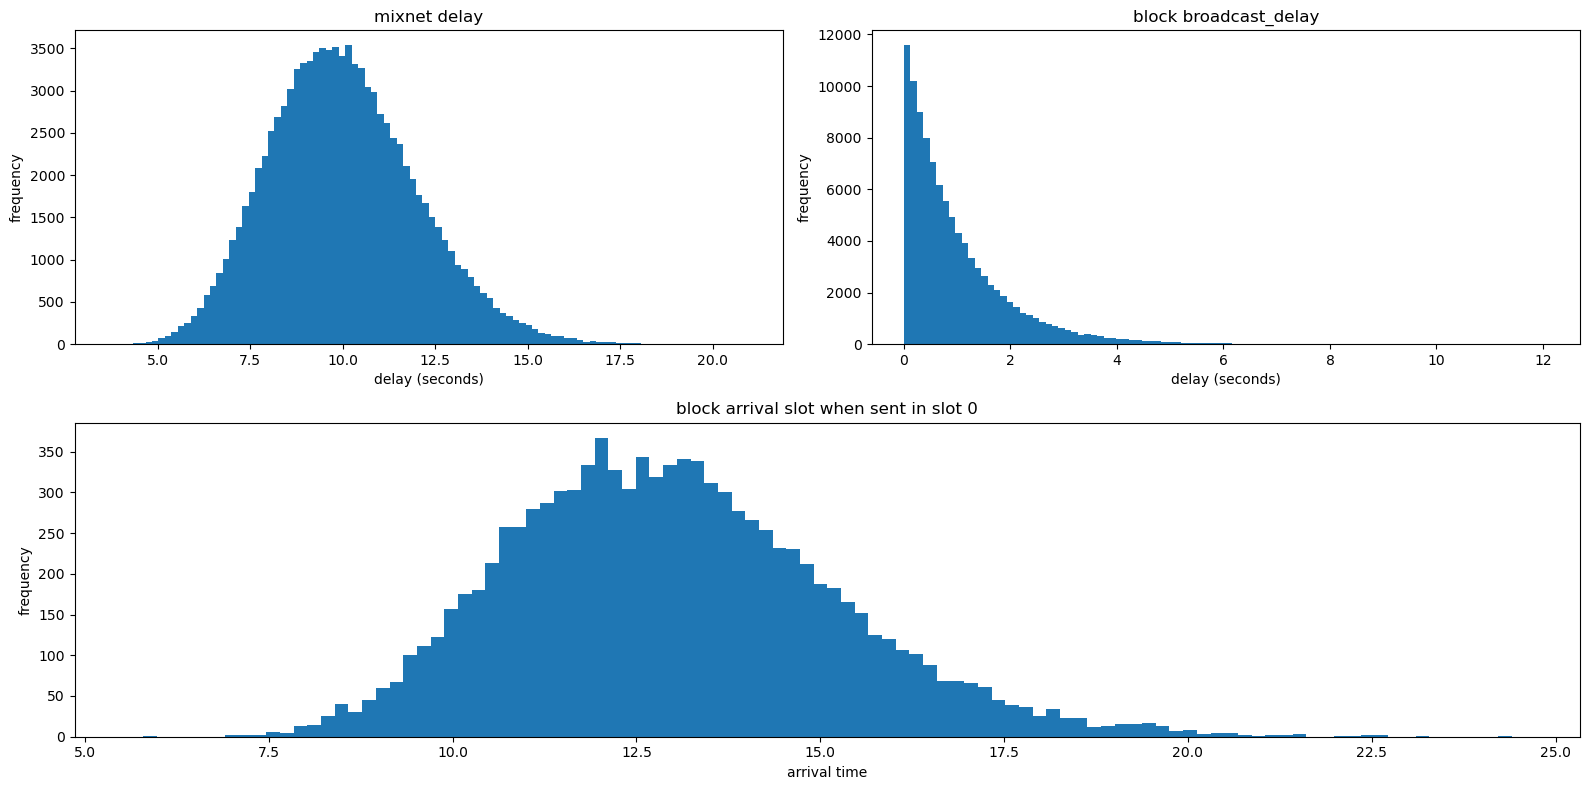

In [6]:
network = NetworkParams(
    mixnet_delay_mean=10, # seconds
    mixnet_delay_var=4,
    broadcast_delay_mean=1, # second
    pol_proof_time=2, # seconds
)


mixnet_delay_data = np.array([network.sample_mixnet_delay() for _ in range(100000)])

plt.figure(figsize=(16,8))
ax = plt.subplot(221)
_ = ax.hist(mixnet_delay_data, bins=100)
ax.set_title(f"mixnet delay")
_ = ax.set_ylabel("frequency")
_ = ax.set_xlabel("delay (seconds)")

broadcast_delay_data = network.sample_broadcast_delay(np.zeros(100000))
ax = plt.subplot(222)
_ = ax.hist(broadcast_delay_data, bins=100)
ax.set_title(f"block broadcast_delay")
ax.set_ylabel("frequency")
ax.set_xlabel("delay (seconds)")

BLOCK_TIME = 0
block_arrival_slots = np.array([network.block_arrival_time(np.array([BLOCK_TIME])) for _ in range(10000)])

ax = plt.subplot(212)
_ = ax.hist(block_arrival_slots, bins=100)
ax.set_title(f"block arrival slot when sent in slot {BLOCK_TIME}")
ax.set_ylabel("frequency")
ax.set_xlabel("arrival time")

plt.tight_layout()

In [7]:
params.next_block().argmax()

821

In [8]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.events = {}
        self.blocks = []
        self.block_heights = np.array([], dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

    def emit_block(self, t, leader, height, parent):
        assert type(t) in [float, np.float64], type(t)
        assert type(leader) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]
    
        block = Block(
            id=len(self.blocks),
            t=t,
            height=height,
            parent=parent,
            leader=leader
        )
        self.blocks.append(block)
        self.block_heights = np.append(self.block_heights, block.height)
    
        # decide when this block will arrive at each node
        self.block_arrivals = np.append(self.block_arrivals, self.network.block_arrival_time(np.repeat(t, self.params.N).reshape((self.params.N, 1))), axis=1)
        return block.id

    def emit_leader_block(self, leader, slot, parent):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)
        assert type(parent) in [int, np.int64], type(parent)
    
        refs = self.select_refs(leader, parent, slot)
        return self.emit_block(
            leader,
            slot,
            weight=self.blocks[parent].weight + len(refs) + 1,
            height=self.blocks[parent].height + 1,
            parent=parent,
            refs=refs
        )

    def select_refs(self, node: int, parent: int, slot: int) -> list[id]:
        assert type(node) in [int, np.int64], node
        assert type(parent) in [int, np.int64], parent
        assert type(slot) in [int, np.int64], slot
    
        if self.blocks[parent].parent >= 0:
            parents_siblings = self.block_siblings(node, self.blocks[parent].parent, slot)
            # we are uniformly sampling from power_set(forks)
            return np.array(parents_siblings)[np.random.uniform(size=len(parents_siblings)) < 0.5]
        else:
            return []
    
    def block_siblings(self, node, block, slot):
        blocks_seen_by_node = self.block_arrivals[node,:] <= slot
        parent = self.blocks[block].parent
        if parent == -1:
            return [block] if blocks_seen_by_node[block] else []
        successor_blocks = self.block_slots > self.blocks[parent].slot
        candidate_siblings = np.nonzero(blocks_seen_by_node & successor_blocks)[0]
        return [b for b in candidate_siblings if self.blocks[b].parent == parent]

    def run(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        t = 0.0
        
        # emit the genesis block
        self.emit_block(
            t,
            leader=0,
            height=1,
            parent=-1,
        )
        self.block_arrivals[:,:] = 0 # all nodes see the genesis block immediately

        while t < self.params.TIME:
            next_block_times = self.params.next_block()
            leader = next_block_times.argmin()
            t += next_block_times[leader]

            seen_blocks = self.block_arrivals[leader] <= t
            seen_heights = self.block_heights * seen_blocks
            fork_heads = (seen_heights == seen_heights.max()) * (seen_heights > 0)
            block_ids = np.nonzero(fork_heads)[0]
            parent = np.random.choice(block_ids)
                        
            self.emit_block(
                t,
                leader=leader,
                height=self.blocks[parent].height + 1,
                parent=parent
            )

    def plot_spacetime_diagram(self, MAX_T=1 * 60 * 60):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_hash_power[n])
        nodes = [f"$N_{n}$($\\alpha$={self.params.relative_hash_power[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].t, arrival_t, f"$B_{{{b}}}$") for b, arrival_ts in enumerate(self.block_arrivals.T) for node, arrival_t in enumerate(arrival_ts) if arrival_t < MAX_T]
    
        fig, ax = plt.subplots(figsize=(8,8))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="black", lw=0.5))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Time')
        
        plt.tight_layout()
        plt.show()

    def honest_chain(self):
        chain_head = max(self.blocks, key=lambda b: b.height)
        honest_chain = {chain_head.id}
        
        curr_block = chain_head
        while curr_block.parent >= 0:
            honest_chain.add(curr_block.parent)
            curr_block = self.blocks[curr_block.parent]
        return sorted(honest_chain, key=lambda b: self.blocks[b].height)

    def visualize_chain(self):
        honest_chain = self.honest_chain()
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.height
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=level, color=color, label=f"{block.t}")
            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=2, color=color)
        
        return G.show("chain.html")

    def adverserial_analysis(self):
        np.random.seed(0)
        adversary = self.params.N - 1
        
        reorg_depths = []
        honest_chain = self.honest_chain()
        print("honest_chain length", len(honest_chain))
        
        for block in self.blocks:
            nearest_honest_block = block
            while nearest_honest_block.height >= len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                nearest_honest_block = self.blocks[nearest_honest_block.parent]
        
            
            adversary_blocks = []
            already_reorged = set()
            t = block.t
            while t < self.params.TIME:
                adversary_block_t = int(self.params.next_block()[adversary])
                t += adversary_block_t
                adversary_blocks.append(t)
                adverserial_height = block.height + len(adversary_blocks)
                honest_chain_up_to_t = [
                    b for b in honest_chain
                    if self.blocks[b].t <= t
                ]
                last_honest_block = self.blocks[honest_chain_up_to_t[-1]]
                assert last_honest_block.height >= nearest_honest_block.height, (t, last_honest_block, nearest_honest_block)
                if last_honest_block.height < adverserial_height:
                    reorg_depths += [last_honest_block.height - nearest_honest_block.height]
                # reorged_blocks = [
                #     b for b in honest_chain
                #     if b not in already_reorged
                #         and self.blocks[b].height > nearest_honest_block.height
                #         and self.blocks[b].height < adverserial_height
                # ]
                # already_reorged |= set(reorged_blocks)
                # reorg_depths += [self.blocks[b].height - nearest_honest_block.height for b in reorged_blocks]
        
        
        plt.hist(reorg_depths, bins=max(reorg_depths, default=1))
        plt.xticks(minor=True)
        plt.title(f"reorg depths with {self.params.adversary_control * 100:.0f}% adversary")
        plt.show()

blocks 184
blocks time 0.33m
honest_chain length 120


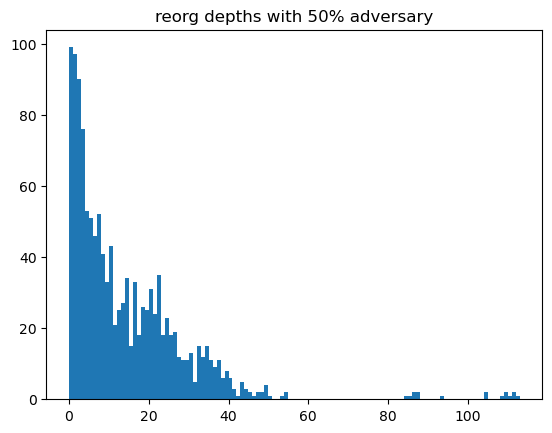

In [9]:
np.random.seed(0)
sim = Sim(
    params=Params(
        TIME=1 * 60 * 60, # seconds
        MEAN_BLOCK_TIME=20,
        honest_hash_power = np.random.pareto(10, size=10),
        adversary_control=0.5,
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=1, # second
        pol_proof_time=2, # seconds
    )
)

sim.run(seed=1)
print("blocks", len(sim.blocks))
print(f"blocks time {sim.params.TIME / len(sim.blocks) / 60:.2f}m")
np.random.seed(0)
sim.adverserial_analysis()

In [10]:
sim.visualize_chain()

Honest chain length 120
chain.html


In [ ]:
sim = Sim(
    params=Params(
        TIME=25 * 60 * 60, # seconds
        MEAN_BLOCK_TIME=20,
        honest_hash_power = np.random.pareto(10, size=10),
        adversary_control=0.2,
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=1, # second
        pol_proof_time=2, # seconds
    )
)

sim.run()
print("blocks", len(sim.blocks))
print(f"blocks time {sim.params.TIME / len(sim.blocks) / 60:.2f}m")
sim.adverserial_analysis()

In [ ]:
sim = Sim(
    params=Params(
        TIME=25 * 60 * 60, # seconds
        MEAN_BLOCK_TIME=20,
        honest_hash_power = np.random.pareto(10, size=10),
        adversary_control=0.1,
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=1, # second
        pol_proof_time=2, # seconds
    )
)

sim.run()
print("blocks", len(sim.blocks))
print(f"blocks time {sim.params.TIME / len(sim.blocks) / 60:.2f}m")
sim.adverserial_analysis()

In [ ]:
N = 100
net_params = [NetworkParams(
        mixnet_delay_mean=0.1, # seconds
        mixnet_delay_var=0.1,
        broadcast_delay_mean=0.1, # second
        pol_proof_time=i/N * 5, # seconds
    ) for i in range(N)]

sims = [Sim(
    params=Params(
        TIME=5 * 60 * 60, # seconds
        MEAN_BLOCK_TIME=20,
        honest_hash_power = np.random.pareto(10, size=10),
        adversary_control=0.1,
    ),
    network=net
) for net in net_params]

[sim.run() for sim in sims]


plt.scatter([sim.network.pol_proof_time / sim.params.MEAN_BLOCK_TIME for sim in sims], [100 - 100 * len(sim.honest_chain()) / len(sim.blocks) for sim in sims])
plt.ylabel("wasted blocks %")
plt.xlabel("PoL time as fraction of mean block time")